In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

In [13]:
import util
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.neural_network import MLPClassifier

In [3]:
### ignore warnings caused by librosa 
import warnings
warnings.filterwarnings("ignore")

In [28]:
SAMPLE_RATE = 22050

In [29]:
T = 4.0    # seconds
t = np.linspace(0, T, int(T*SAMPLE_RATE), endpoint=False) # time variable
freq = 440
signal = np.sin(2*np.pi*freq*t)

In [30]:
train = np.load("data/train.npy")
X_train = train[:,1:]
y_train = train[:,0]
X_labeled = X_train[y_train != -1]
y_labeled = y_train[y_train != -1]
X_unlabeled = X_train[y_train == -1]
y_unlabeled = y_train[y_train == -1]
del train

test = np.load("data/test.npy")
X_test = test[:,1:]
del test

In [31]:
# save everything so your life stops ending every time kernel crashes
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_labeled.npy", X_labeled)
np.save("y_labeled.npy", y_labeled)
np.save("X_test.npy", X_test)

In [32]:
# Just some re-shaping and dimension finding
N = 6374
print("N:",N)
print("Train shape",X_train.shape)
N_train = X_train.shape[0]
NUM_SAMPLES = X_train.shape[1]-1

N: 6374
Train shape (6374, 88200)


In [33]:
# JUST SOME FOURIER TRANSFORM PARAMETERS
BINS_OCTAVE = 12*2
N_OCTAVES = 7
NUM_BINS = BINS_OCTAVE * N_OCTAVES

In [34]:
# Given a wav time series, makes a mel spectrogram
# which is a short-time fourier transform with
# frequencies on the mel (log) scale.
def mel_spec(y):
    Q = librosa.cqt(y=y, sr=SAMPLE_RATE, bins_per_octave=BINS_OCTAVE,n_bins=NUM_BINS)
    Q_db = librosa.amplitude_to_db(Q,ref=np.max)
    return Q_db

In [16]:
# This means that the spectrograms are 168 rows (frequencies)
# By 173 columns (time frames)
song = X_train[0]
test_spec = mel_spec(song)
print(test_spec.shape)
FEATS = test_spec.shape[0]
FRAMES = test_spec.shape[1]

(168, 173)


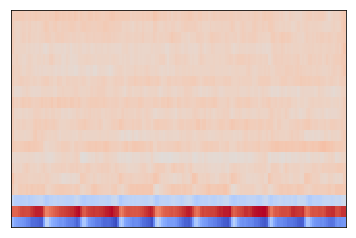

In [26]:
# librosa.display.specshow(tmp_train[2], y_axis='hz')
librosa.display.specshow(mfccs[17])#, y_axis='hz')

In [50]:
mfccs[17].shape

(20, 173)

In [18]:
signal = X_train[0]
librosa.feature.mfcc(signal).shape
mel_spec(signal).shape

(168, 173)

In [35]:
def get_feats(d):
    mfccs = []
    mels = []
    tempos = []
    tempograms = []
    for signal in d:
        mfcc = librosa.feature.mfcc(signal)
        mel = np.mean(mel_spec(signal), axis = 0)
        tempo = librosa.beat.tempo(signal)[0]
        tempogram = np.mean(librosa.beat.tempogram(signal), axis = 0)
        mfccs.append(mfcc)
        mels.append(mel)
        tempos.append(tempo)
        tempograms.append(tempograms)
    return mfccs, mels, tempos, tempograms

In [ ]:
data = zip(X_labeled, y_labeled)



mfccs, mels, tempos, tempograms = get_feats(data)

# save your features otherwise you will be sad
np.save("mfccs.npy", mfccs)
np.save("mels.npy", mels)
np.save("tempos.npy", tempos)
np.save("tempograms.npy", tempograms)

In [4]:
X_labeled = np.load("X_labeled.npy")
y_labeled = np.load("y_labeled.npy")
data = zip(X_labeled, y_labeled)

In [5]:
mfccs = np.load("mfccs.npy")
mels = np.load("mels.npy")
tempos = np.load("tempos.npy")
tempograms = np.load("tempograms.npy")

In [7]:
X_train = np.load("X_train.npy")

In [9]:
feats = []
for i in range(len(tempos)):
    feat = np.concatenate((mfccs[i].flatten(), mels[i]))
    feats.append(feat)      

            

In [63]:
len(mfccs[i][3:].flatten())

2941

3634

In [10]:
scale0 = scale(feats)

In [52]:
scale2 = scale(feats2)

In [8]:
labels = np.load("y_labeled.npy")

In [54]:
params = {"n_neighbors": [1]}
gs = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs.fit(scale0, labels)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   11.5s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=3)

In [55]:
print(gs.best_params_), 
gs.best_score_

{'n_neighbors': 1}

0.6545296922410057

In [65]:
params = { }
gs = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs.fit(scale0, labels)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.8s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [66]:
print(gs.best_params_), 
gs.best_score_

{}

0.6376246207195492

In [11]:

params = {}
gs2 = GridSearchCV(KMeans(n_clusters=10,max_iter=5000), params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs2.fit(scale0, labels)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   32.1s finished


GridSearchCV(cv=4, error_score='raise',
       estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=5000,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [12]:
gs2.best_score_

0.09406155179887299

In [14]:
mfccs_trunc = mfccs[:,3:,:]
mfccs_trunc.shape
mfccs_trunc = mfccs_trunc.reshape((2307, 17*173))

In [19]:
rfc = RandomForestClassifier(n_estimators=200)
params = { }
gs3 = GridSearchCV(rfc, params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs3.fit(scale(mfccs_trunc), labels)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.0min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [20]:
gs3.best_score_

0.6419592544429996

In [17]:
params = { }
gs4 = GridSearchCV(MLPClassifier(), params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gs4.fit(scale(mfccs_trunc), labels)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.2min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [18]:
gs4.best_score_

0.5929778933680104

## predicting stuff

In [73]:
X_test = np.load("X_test.npy")
test_feats = []

mfccs, mels, tempos, tempograms = get_feats(X_test)
for i in range(len(tempos)):
    feat = np.concatenate((np.array([tempos[i]]), mfccs[i].flatten(), mels[i]))
    test_feats.append(feat)      


In [74]:
preds = gs.best_estimator_.predict(test_feats)
# util.write_predictions(preds, range(len(preds)), "rfc, mfccflat, melmean, tempo, scaled.csv")

In [76]:
for x in preds:
    print x

2.0
2.0
5.0
2.0
5.0
2.0
2.0
3.0
2.0
5.0
2.0
5.0
2.0
5.0
2.0
5.0
5.0
5.0
5.0
9.0
2.0
5.0
5.0
5.0
5.0
0.0
5.0
2.0
3.0
3.0
5.0
5.0
5.0
2.0
5.0
0.0
2.0
3.0
2.0
5.0
5.0
5.0
5.0
5.0
9.0
5.0
3.0
2.0
5.0
5.0
2.0
5.0
5.0
3.0
5.0
3.0
2.0
5.0
5.0
2.0
5.0
5.0
5.0
5.0
5.0
5.0
3.0
2.0
0.0
5.0
2.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
2.0
5.0
5.0
2.0
5.0
5.0
3.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
0.0
5.0
2.0
5.0
5.0
5.0
3.0
5.0
3.0
2.0
5.0
2.0
2.0
0.0
2.0
5.0
2.0
5.0
2.0
2.0
0.0
3.0
5.0
5.0
2.0
5.0
0.0
5.0
5.0
5.0
5.0
3.0
5.0
0.0
5.0
2.0
2.0
0.0
5.0
5.0
2.0
5.0
5.0
2.0
5.0
9.0
5.0
5.0
5.0
5.0
3.0
2.0
5.0
0.0
5.0
2.0
2.0
5.0
5.0
5.0
2.0
2.0
5.0
3.0
5.0
5.0
2.0
2.0
5.0
5.0
5.0
5.0
2.0
5.0
3.0
5.0
3.0
3.0
2.0
5.0
5.0
2.0
5.0
3.0
5.0
5.0
2.0
5.0
5.0
2.0
5.0
2.0
2.0
2.0
5.0
5.0
2.0
3.0
5.0
5.0
2.0
2.0
5.0
2.0
2.0
5.0
5.0
5.0
3.0
5.0
5.0
5.0
5.0
2.0
2.0
5.0
5.0
5.0
2.0
5.0
5.0
3.0
2.0
5.0
2.0
5.0
2.0
5.0
5.0
5.0
5.0
5.0
3.0
5.0
5.0
2.0
5.0
5.0
2.0
5.0
2.0
5.0
2.0
2.0
2.0
2.0
2.0
2.0
5.0
5.0
2.0
5.0
5.0
2.0
5.0
5.0
2.0
